<a href="https://colab.research.google.com/github/tatsubori/Baselines-ETCI2021/blob/main/ECTI_Jumpstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to use a GPU for training the model! 

You can run this code with GPU by:
1. Go to Runtime tab in the toolbar at the top of this website
2. Select 'Change runtime type'
3. In dropdown menu select 'GPU'
4. Click 'save' and then reconnect the notebook

In [25]:
# need to run and restart instance
!pip install -U git+https://github.com/albu/albumentations --no-cache-di
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-e191eyrp
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-e191eyrp
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=123902 sha256=5d77d274b2f4348adb299617d0e66f3cb83a66bd2127a7b66858422ec823de7e
  Stored in directory: /tmp/pip-ephem-wheel-cache-qsfncno0/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.9 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
 

In [26]:
# Set up plotting options
%matplotlib inline

In [27]:
# load packages
import os
import sys
import cv2
import gdown
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
from torch.utils.data import Dataset, DataLoader

# Download dataset

### Download training and validation datasets from Google Drive links

In [28]:
# check if files are already downloaded
dset_download = os.path.isdir('/content/ETCI_2021_Competition_Dataset/train/')

if dset_download is False:
  url = 'https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr'
  output = 'train.tgz'
  gdown.download(url, output, quiet=False)

  url = 'https://drive.google.com/uc?id=1GWl3g1G152Rinxc1Fbc-JkSWlRQNWKBK'
  output = 'valid.tgz'
  gdown.download(url, output, quiet=False)

### Move and unzip files

In [29]:
if dset_download is False:
  !mkdir -p /content/ETCI_2021_Competition_Dataset
  
  !mv /content/train.tgz /content/ETCI_2021_Competition_Dataset/
  !mv /content/valid.tgz /content/ETCI_2021_Competition_Dataset/

  !unzip -q /content/ETCI_2021_Competition_Dataset/train.tgz -d /content/ETCI_2021_Competition_Dataset
  !unzip -q /content/ETCI_2021_Competition_Dataset/valid.tgz -d /content/ETCI_2021_Competition_Dataset

# Set path to where dataset is downloaded

In [30]:
# path to dataset root directory
dset_root = '/content/ETCI_2021_Competition_Dataset/'

In [31]:
# get number of training/validation regions
train_dir = os.path.join(dset_root, 'train')
valid_dir = os.path.join(dset_root, 'val')

n_train_regions = len(glob(train_dir+'/*/'))
n_valid_regions = len(glob(valid_dir+'/*/'))

# NOTE: make sure number of regions is NOT 0
print('Number of training temporal-regions: {}'.format(n_train_regions))
print('Number of validation temporal-regions: {}'.format(n_valid_regions))

Number of training temporal-regions: 31
Number of validation temporal-regions: 10


# Helper functions

In [32]:
def get_filename(filepath):
    return os.path.split(filepath)[1]


def visualize(df_row, figsize=[25, 15]):
    # get image paths
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

    # create RGB image from S1 images
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

    # get water body label mask
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

    # plot images
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
        # plot RGB S1 image
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot water body mask
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0

        # plot RGB S1 image
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot flood label mask
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

        # plot water body mask
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')


def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

def visualize_result(df_row, prediction, figsize=[25, 15]):
    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
    rgb_input = s1_to_rgb(vv_image, vh_image)

    plt.figure(figsize=tuple(figsize))
    plt.subplot(1,2,1)
    plt.imshow(rgb_input)
    plt.title('RGB w/ result')
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title('Result')

# Create training and validation dataframes

In [33]:
vv_image_paths = sorted(glob(train_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = vv_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


train_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


train_df = pd.DataFrame(train_paths)

print(train_df.shape)
train_df.head()

(33405, 5)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
1,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
2,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
3,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh
4,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,/content/ETCI_2021_Competition_Dataset/train/b...,bangladesh


In [34]:
vv_image_paths = sorted(glob(valid_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(valid_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path ()
    flood_label_paths.append(np.NaN)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(valid_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)

valid_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


valid_df = pd.DataFrame(valid_paths)
valid_df.sort_values(by=['vv_image_path'])  # important line for submitting results

print(valid_df.shape)
valid_df.head()

(10400, 5)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
1,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
2,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
3,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence
4,/content/ETCI_2021_Competition_Dataset/val/flo...,/content/ETCI_2021_Competition_Dataset/val/flo...,NaN,/content/ETCI_2021_Competition_Dataset/val/flo...,florence


# Visualize some imagery from training and validation sets

### Training set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


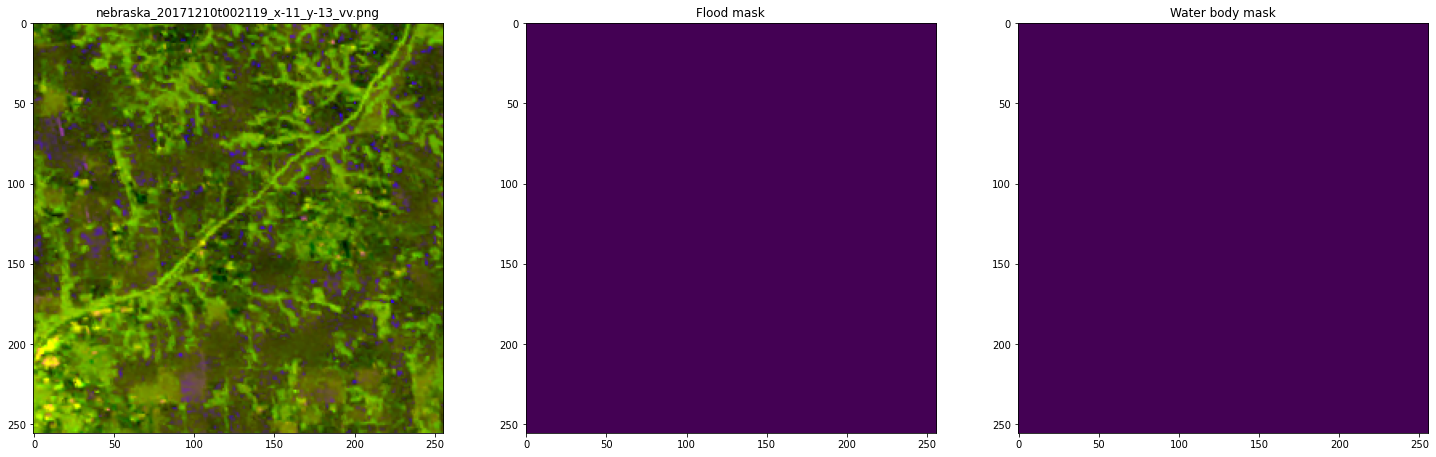

In [35]:
visualize(train_df.iloc[16501])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


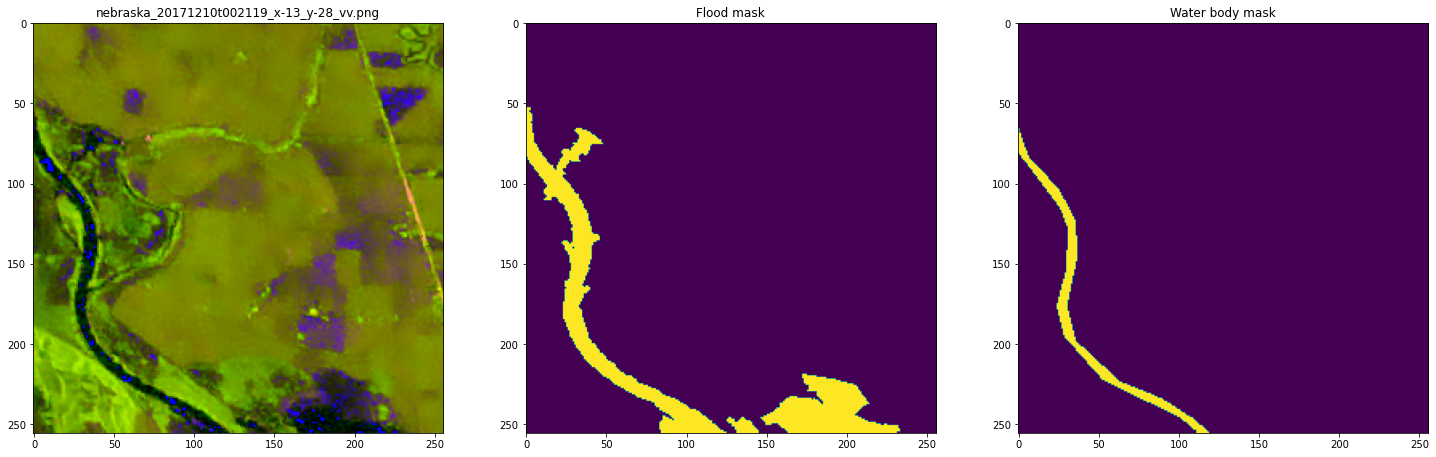

In [36]:
visualize(train_df.iloc[16601])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


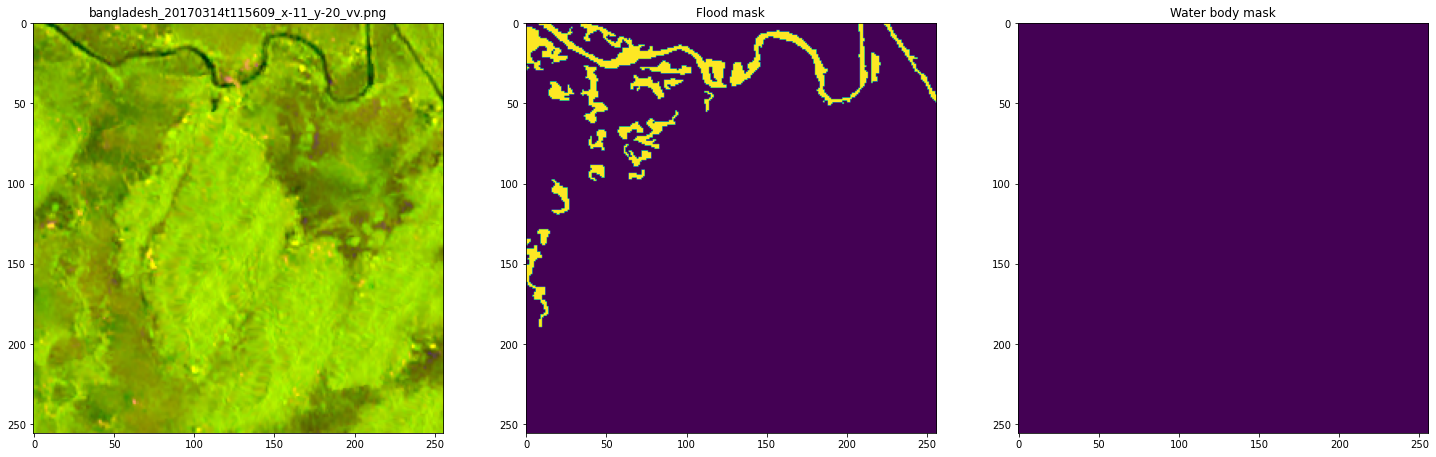

In [37]:
visualize(train_df.iloc[100])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


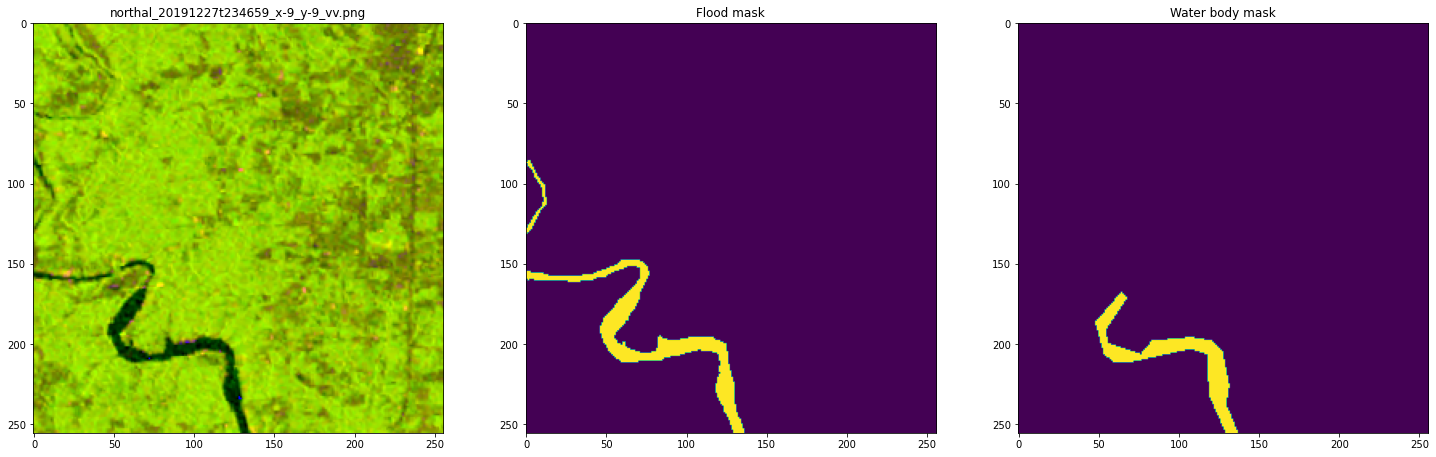

In [38]:
visualize(train_df.iloc[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


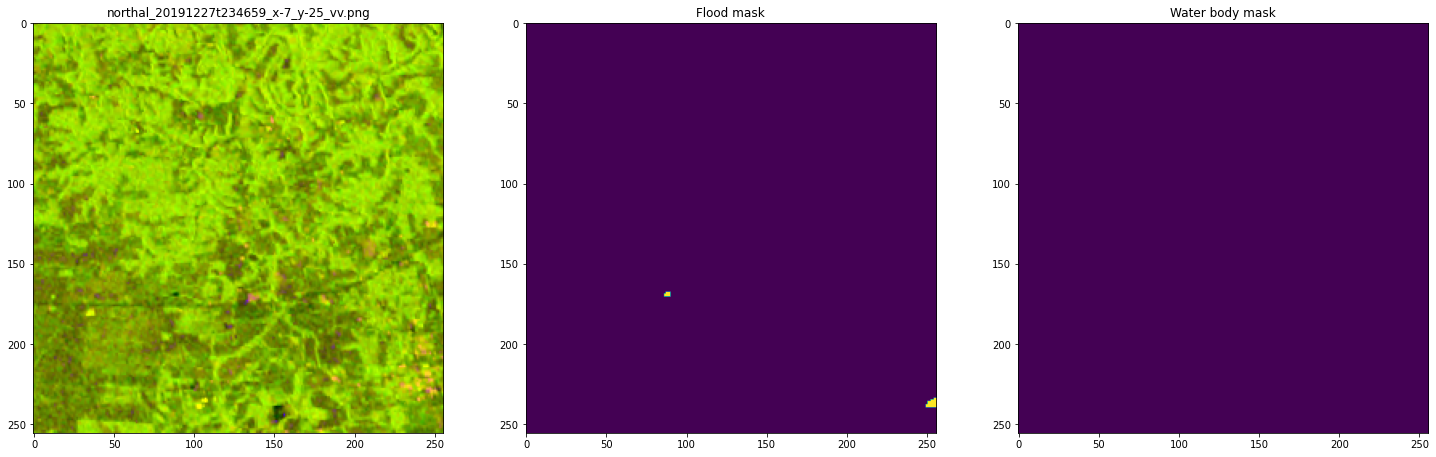

In [39]:
visualize(train_df.iloc[-100])

### Validation set

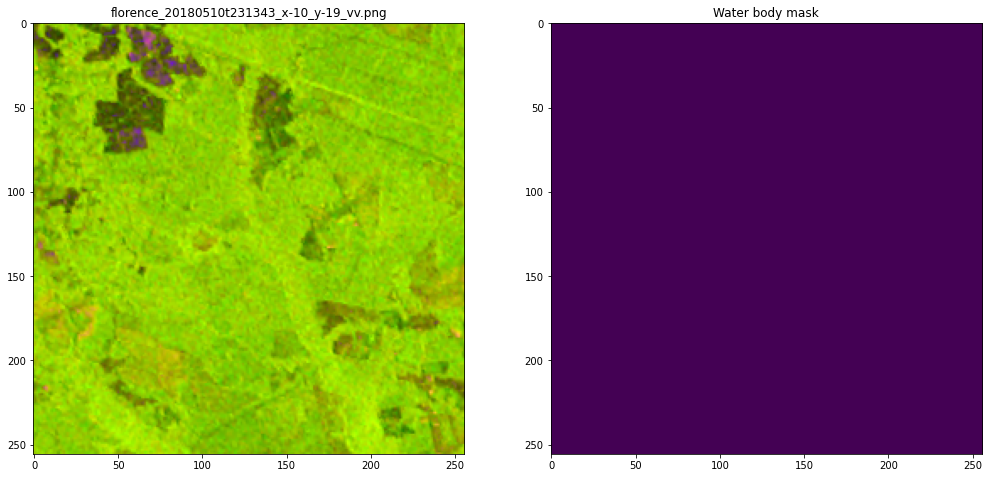

In [40]:
visualize(valid_df.iloc[50], figsize=(17,10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


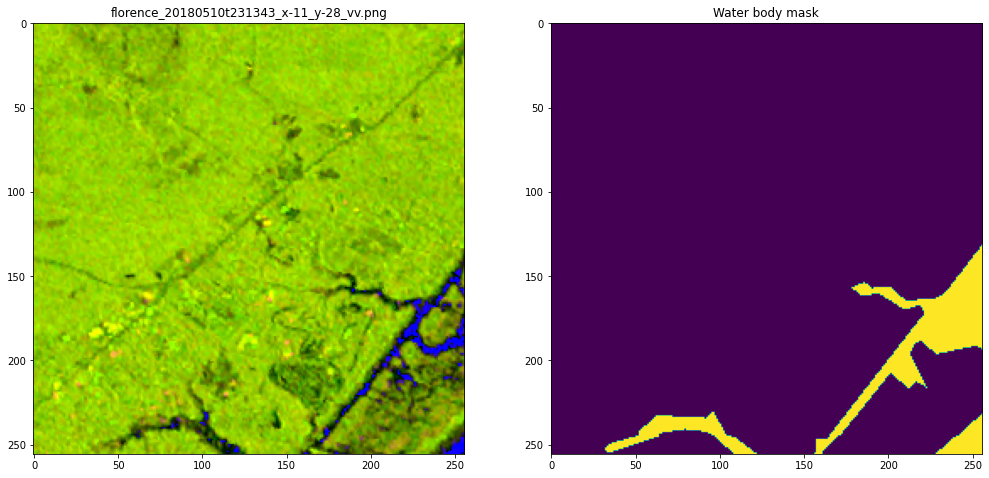

In [41]:
visualize(valid_df.iloc[100], figsize=(17,10))

# Setup dataset for machine learning

Since we do not have flood labels for the validation set of this dataset, we will not be able to fairly evaluate our trained model for the flood segmentation task. Instead we can split our training dataset (that contains flood masks) into a smaller training and development set. We will leave the true validation set for inference in another section.


### Split training set into training and development sets

There are a variety of ways to split a dataset but for this guide we will separate the training set by regions. This splitting method will simulate what the model will recieve in the validation set because there are no regions that overlap between the training and validation sets.

In [42]:
# all regions in the training set
regions = ['nebraska', 'northal', 'bangladesh']

# randomly choose one for the development set and leave the rest for training
development_region = np.random.choice(regions, 1)[0]
regions.remove(development_region)
train_regions = regions

print('Training regions: {}'.format(train_regions))
print('Development region: {}'.format(development_region))

Training regions: ['nebraska', 'bangladesh']
Development region: northal


In [43]:
# filter the dataframe to only get images from specified regions
sub_train_df = train_df[train_df['region'] != development_region]
development_df = train_df[train_df['region'] == development_region]

In [44]:
# check that new dataframes only have the image paths from the correct regions
print('Sub-training set regions: {}'.format(np.unique(sub_train_df['region'].tolist())))
print('Development set region: {}'.format(np.unique(development_df['region'].tolist())))

Sub-training set regions: ['bangladesh' 'nebraska']
Development set region: ['northal']


### Create a PyTorch dataset

We will be using the PyTorch deep learning library to format this dataset and create our machine learning model. Therefore we will need to create a custom Dataset class and pass it into a DataLoader object (see this tutorial for a more about this topic: [PyTorch Dataset Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). To compute image transformations we will use the [Albumentations](https://github.com/albumentations-team/albumentations) package.

In [45]:
class ETCIDataset(Dataset):
    def __init__(self, dataframe, split, transform=None):
        self.split = split
        self.dataset = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]


    def __getitem__(self, index):
        example = {}
        
        df_row = self.dataset.iloc[index]

        # load vv and vh images
        vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
        vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
        
        # convert vv and ch images to rgb
        rgb_image = s1_to_rgb(vv_image, vh_image)

        if self.split == 'test':
            # no flood mask should be available
            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
        else:
            # load ground truth flood mask
            flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

            # compute transformations
            if self.transform:
                augmented = self.transform(image=rgb_image, mask=flood_mask)
                rgb_image = augmented['image']
                flood_mask = augmented['mask']

            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
            example['mask'] = flood_mask.astype('int64')

        return example



In [46]:
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(width=256, height=256)
])

train_dataset = ETCIDataset(sub_train_df, split='train', transform=transform)
development_dataset = ETCIDataset(development_df, split='devlopment', transform=None)

In [47]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
development_loader = DataLoader(development_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Create a deep learning model

Now we need to create a model that will learn how to predict floop maps from Sentinel 1 imagery. 

### Select hardware to train model

In [48]:
device = 'cuda'  # use 'cpu' if your computer does not have a GPU

### Take a model from off the shelf

We will grab a segmentation model from the [Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch) package.

In [49]:
def create_model():
  # load model from package
  model = smp.Unet(
      encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
      encoder_weights=None,           # use `imagenet` pre-trained weights for encoder initialization
      in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
      classes=2,                      # model output channels (number of classes in your dataset)
  )
  return model

model = create_model()

In [50]:
# load model into GPU or CPU memory
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Get model optimizer and loss function

In [51]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criteria = nn.CrossEntropyLoss()

# Train model

In [52]:
# set the number of times you want the model to see all of the training data
epochs = 5

### Metric tracker

In [53]:
from sklearn.metrics import confusion_matrix

class iouTracker:
    def __init__(self, n_classes=2, smooth=0.0001):
        self.n_classes = n_classes
        self.reset()
        self.smooth = smooth

    def reset(self):
        self.cm = np.zeros((self.n_classes, self.n_classes))
        self.count = 0
    
    def update(self, pred, target):
        # pred: [B, 2, H, W]
        # target: [B, H, W]
        self.count += pred.shape[0]

        # reshape inputs
        pred = pred.argmax(dim=1).flatten()  # [B*H*W]
        target = target.flatten()  # [B*H*W]

        # put into cpu memory
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()

        # compute confusion matrix values
        self.cm += confusion_matrix(target, pred)

    def get_mean(self):
        tn, fp, fn, tp = self.cm.ravel()

        # compute IoU
        iou = tp / (tp + fp + fn + self.smooth)

        return iou

### Training loop

In [ ]:
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_loader)
    model.train()
    iou_logger = iouTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)

        # pass images into model
        pred = model(image)

        # get loss
        loss = criteria(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute and display progress
        iou_logger.update(pred, mask)
        mIoU = iou_logger.get_mean()
        pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f}'.format(loss.item(), mIoU))

    # development set
    pbar = tqdm(development_loader)
    model.eval()
    iou_logger = iouTracker()
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model(image)

            # get loss
            loss = criteria(pred, mask)
            
            # compute and display progress
            iou_logger.update(pred, mask)
            mIoU = iou_logger.get_mean()
            pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f}'.format(loss.item(), mIoU))

# save model
torch.save(model.state_dict(), 'model.pt')


Epoch: [1/5]


  0%|          | 0/288 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


# Test model

### Create 'test' dataset
We need to order the validation set according to [Validation files sequence](https://docs.google.com/spreadsheets/d/1F5SaAIVwuBcYS1v8rOXZcJqRPnbB6z8S0zir1-I0K5Y/edit?usp=sharing). We did this earlier when we sorted the valid_df object by the vv_image_path column. That means we can create Dataset and DataLoader objects just as we did with the development set.

In [ ]:
# load model
model = create_model()
model.load_state_dict(torch.load('model.pt'))
model.to(device)

valid_dataset = ETCIDataset(valid_df, split='test', transform=None)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)  # make sure shuffle is False

final_predictions = []

model.eval()
with torch.no_grad():
    for batch in tqdm(valid_loader):
        # load image and mask into device memory
        image = batch['image'].to(device)

        # pass images into model
        pred = model(image)

        # compute class predictions, i.e. flood or no-flood
        class_pred = pred.argmax(dim=1)

        # convert class prediction to numpy
        class_pred = class_pred.detach().cpu().numpy()

        # add to final predictions
        final_predictions.append(class_pred.astype('uint8'))


# this should give you a result of 0.4 on ranking board
final_predictions = np.concatenate(final_predictions, axis=0)

# check final prediction shape
print(final_predictions.shape)

### View our results
Note the result and input images will not align perfectly because we are taking the input image before the random crop and resize.

In [ ]:
index = 252
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

In [ ]:
index = -100
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

In [ ]:
index = -1910
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

In [ ]:
index = -1919
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

# Create submission
Need to make sure that the test set is in the correct order!

In [ ]:
# save final predictions as a .zip file
save_path = './submission.npy'
np.save(save_path, final_predictions, fix_imports=True, allow_pickle=False)

In [ ]:
# run if you are using a linux machine
import subprocess
subprocess.run(['zip', 'submission.zip', save_path])

Now download the "submission.zip" file and upload it to Colab to be scored!

# Filter noisy images

As we look through the dataset we find images which appear be artifacts sampling along the edge of the sateliite capute. You may want to remove these images in the training set. We can filter these images by determining if vv or vh only contain binary (0 or 255) values and then remove them from the training dataframe.

In [ ]:
img = cv2.imread(train_df.iloc[1000]['vv_image_path'], 0)
img_values = list(np.unique(img))
print(img_values)
print()

In [ ]:
plt.imshow(img)

In [ ]:
remove_indices = []
for i, image_path in enumerate(train_df['vv_image_path'].tolist()):
    # load image
    image = cv2.imread(image_path, 0)
    
    # get all unique values in image
    image_values = list(np.unique(image))

    # check values
    binary_value_check = (image_values == [0,255]) or (image_values == [0]) or (image_values == [255])

    if binary_value_check is True:
        remove_indices.append(i)

In [ ]:
filtered_train_df = train_df.drop(train_df.index[remove_indices])

In [ ]:
print(f'Number of images originally: {train_df.shape[0]}')
print(f'Number of images after simple filtering: {filtered_train_df.shape[0]}')